In [9]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from symengine import *
from mimiqcircuits import *
from tqdm import tqdm
from scipy.optimize import minimize


connect = MimiqConnection(url="https://mimiq.qperfect.io/api")
connect.connect("marco.vassallo02@gmail.com","Eucalipto03")

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 411/3000 minutes
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

In [10]:
def plot_adjacency_matrix(adj_matrix, title="Adjacency Matrix"):
    plt.figure(figsize=(6,6))
    
    plt.imshow(adj_matrix, cmap='gray_r', interpolation='none')
    plt.title(title)
    plt.colorbar(label="Edge Weight")
    plt.show()

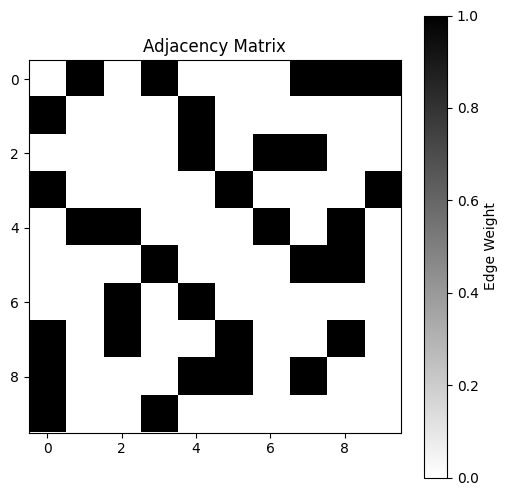

[[0 1 0 1 0 0 0 1 1 1]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 1 0 0]
 [1 0 0 0 0 1 0 0 0 1]
 [0 1 1 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 1 1 0]
 [0 0 1 0 1 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 1 0]
 [1 0 0 0 1 1 0 1 0 0]
 [1 0 0 1 0 0 0 0 0 0]]


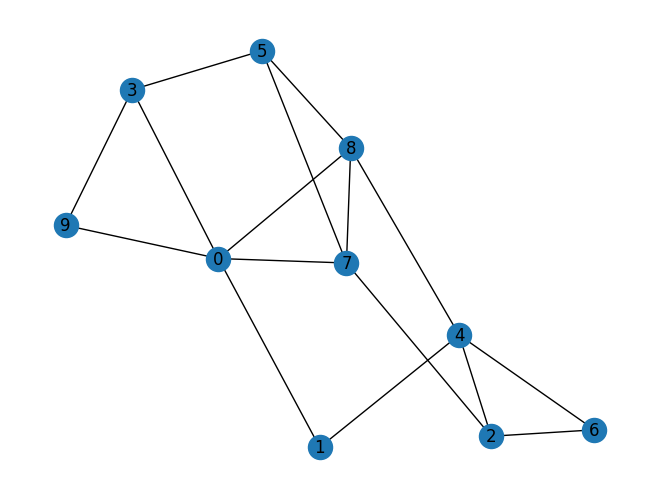

In [11]:
n=10
np.random.seed(1234)
A = np.triu(np.random.randint(0, 2, (n, n)), 1)
adj_martix=A+A.T
plot_adjacency_matrix(adj_martix)
print(adj_martix)
G = nx.Graph(adj_martix)
nx.draw(G, with_labels=True)
def cost(X,A):
    c=np.sum(A,axis=0)
    return -X.T @ A @ X+c.T @ X

In [12]:
def Build_QAOA(B, q, draw=False):
    beta=[symbols(f"beta_{i}") for i in range(q)]
    gamma=[symbols(f"gamma_{i}") for i in range(q)]
    n=len(B) #Qubit number

    c=Circuit() #Circuit definition
    c.push(GateH(), range(0, n))
        
    for k in range(0,q):

        #Block here
        for i in range(0,n) :
            for j in range(i+1,n):
                A_ij = B[i,j]
                if A_ij != 0:
                    c.push(GateRZZ(gamma[k]*A_ij), i, j)    #The Upeer one is ALWAYS the control one

        #Block Here
        
        c.push(GateRX(beta[k]), range(0,n))
        
    if draw:
        c.draw()

    return c

In [13]:
def Run_QAOA(circuit, beta, gamma, connect):
   dict_beta={f"beta_{i}":beta[i] for i in range(len(beta))}
   dict_gamma={f"gamma_{i}":gamma[i] for i in range(len(gamma))}
   full_dict = {**dict_beta, **dict_gamma}
   ev_circ = circuit.evaluate(full_dict)
   job_id = connect.execute(ev_circ,nsamples=10001)
   res = connect.get_result(job_id)
   print(res)
   return res

In [14]:
def Optimizer(params):
    global layer_number
    global shots
    global Time_execution
    circuit = Build_QAOA(adj_martix, layer_number)
    full_dict = {}
    for i in range(len(params)):
        if i < len(params)/2:
            dict_beta={f"beta_{i}":params[i]}
            full_dict.update(dict_beta)
        else:
            j = i-15
            dict_gamma={f"gamma_{j}":params[i]}
            full_dict.update(dict_gamma)            
    ev_circ = circuit.evaluate(full_dict)
    job_id = connect.execute(ev_circ,nsamples=shots)
    res = connect.get_result(job_id)
    Time_execution += res.timings["total"]
    Cost=0
    for state, measures in tqdm( res.histogram().items(), desc="Optimization step"):
        state=np.array(state.tolist())
        Cost+=cost(state,adj_martix)*measures/shots
    return Cost

In [15]:
iteration_cost=[]
def callback(xk):
    iteration_cost.append(Optimizer(xk))



def QAOA(beta_0,gamma_0): 
    global Iterations
    params = np.concatenate([beta_0,gamma_0])
    result = minimize(Optimizer,params,method='Nelder-Mead',options={'maxiter': Iterations},callback=callback)
    return result

In [ ]:
layer_number = 15
shots =30000
Iterations=35
Time_execution = 0

beta_0 = np.random.uniform(0, np.pi, layer_number)
gamma_0 = np.random.uniform(0, np.pi, layer_number)
val=QAOA(beta_0,gamma_0)

params = val.x
best_cost=val.fun

Optimization step: 100%|██████████| 995/995 [00:00<00:00, 107385.75it/s]


In [ ]:
circuit = Build_QAOA(adj_martix, layer_number)

beta_0=params[:len(params)//2]
gamma_0=params[len(params)//2:]

res=Run_QAOA(circuit,beta_0,gamma_0,connect )

ZAVO FROCIO AL: 100%|██████████| 15/15 [00:00<00:00, 3033.49it/s]


QCSResults:
├── simulator: MIMIQ-StateVector 0.18.2
├── timings:
│    ├── parse time: 0.002050688s
│    ├── apply time: 0.025070803s
│    ├── total time: 0.030853589s
│    ├── compression time: 0.002130394s
│    └── sample time: 0.001430268s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"1101010111" => 58
│    ├── bs"1100011001" => 58
│    ├── bs"0001110111" => 56
│    ├── bs"0010101000" => 56
│    └── bs"0011100110" => 50
├── 1 executions
├── 0 amplitudes
└── 10001 samples


In [ ]:
print(iteration_cost)
print("Minimization time", Time_execution)

In [ ]:
p_values=np.linspace(1,16,8,dtype=int)
Iterations = 15
p_circuits=[]

for p in p_values:
    p_circuits.append(Build_QAOA(adj_martix,p))

ZAVO FROCIO AL: 100%|██████████| 16/16 [00:00<00:00, 3452.28it/s]


In [ ]:
plt.plot(iteration_cost, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("Optimization Progress")
plt.grid()
plt.show()

NameError: name 'iteration_cost' is not defined

In [ ]:
#risolvi il problema per vari p, e trova le rispettive cost function
#usando il metodo dentro plotting.py, plotta il grafico

In [ ]:
#risolvi il problema per vari ansatz, e o li grafichiamo o diciamo semplicemente cosa abbiamo fatto

In [ ]:
#fissati p e ansatz, risolviamo di nuovo il problema per vari numero di qubit, anche con il classic solver (dentro classic_solver.py)
#grafichiamo il tempo impiegato nei vari solver rispetto al numero di qubit, con il metodo xy_plotting

In [ ]:
#scelto un problema (cioe N e ansatz) trovare la soluzione e usare il metodo graph plotting per plottare i due sottografi

In [ ]:
#FINE

In [ ]:
# def Optimizer_v2(circuit,Beta_best,Gamma_best,iteration): 
#     Cost_best= 0
#     for i in tqdm(range(iteration), desc="outer one"):
#         Cost=0
#         beta = Beta_best + np.random.normal(0,0.2)
#         gamma = Gamma_best + np.random.normal(0,0.2)
#         state_vector = Run_QAOA(circuit,beta,gamma,connect).histogram()
#         for state, measures in state_vector.items():
#             state=np.array(state.tolist())
#             Cost+=cost(state,D)*measures
#         if(Cost>Cost_best):
#             Cost_best=Cost
#             Beta_best=beta
#             Gamma_best=gamma
#         if(i==iteration-1):
#             return max(state_vector, key=state_vector.get)
#     return 0

iteration=1
layer_number = 1
circuit = Build_QAOA(adj_martix, layer_number)


beta_0 = np.random.uniform(0, np.pi, layer_number)
gamma_0 = np.random.uniform(0, np.pi, layer_number)
val_=Optimizer_v2(circuit,beta_0,gamma_0,iteration)

outer one:   0%|          | 0/1 [00:00<?, ?it/s]

QCSResults:
├── simulator: MIMIQ-StateVector 0.18.2
├── timings:
│    ├── compression time: 0.000278953s
│    ├── total time: 0.004011252s
│    ├── sample time: 0.001597507s
│    ├── parse time: 0.000273744s
│    └── apply time: 0.001738511s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"1010010000" => 82
│    ├── bs"1010010001" => 81
│    ├── bs"1100111111" => 79
│    ├── bs"0101101111" => 77
│    └── bs"1011010000" => 76
├── 1 executions
├── 0 amplitudes
└── 10001 samples


outer one:   0%|          | 0/1 [00:02<?, ?it/s]
